In [112]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, Pauli, Statevector, SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd

In [347]:
from qiskit import transpile
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [170]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='d971f21d7a3ef5423c79cb3cee59a1a2d2ebffbe7c6814abc54679456cd3005eafb563e6c1356898c29cfc8b038279958d966dc3d726c2ef7f7f87c2f03a5849'
)

<QiskitRuntimeService>

## Estimate using Simulator

In [162]:
def z_expected_value(qc, true_expected_value, shots_list):
    """Calculate expectation of Z using AerSimulator."""
    backend = AerSimulator()
    expectation_Z = []
    
    for shots in shots_list:
        job = backend.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts()
        
        # Calculate expectation value of Z
        z_value = (counts.get('0', 0) - counts.get('1', 0)) / shots
        expectation_Z.append(z_value)
    
    #print(f"Expectation values of Z: {expectation_Z}")
    return expectation_Z

    #print(f"expected error is {2*np.sqrt(counts.get('0', 0) * counts.get('1', 0) / shots**3):.1e}")
    #print(f"actual error is {np.abs(expectation_Z - true_expected_value):.1e}")

## Estimate using IBM chip

In [207]:
def z_expected_value(qc: QuantumCircuit, true_expected_value: float):
    """Calculate expectation of Z, using Aer simulator."""
    shots = 1000
    # Initialize runtime service
    backend = service.least_busy(operational=True, min_num_qubits=1)

    sampler = Sampler(mode=backend)
    job = sampler.run([qc], shots=1000)
    result = job.result()
    counts = result.quasi_dists[0]

    # Calculate expectation value of Z
    expectation_Z = (counts.get('0', 0) - counts.get('1', 0)) / shots
    print(f"Expectation value of Z: {expectation_Z}")

    print(f"expected error is {2*np.sqrt(counts.get('0', 0) * counts.get('1', 0) / shots**3):.1e}")
    print(f"actual error is {np.abs(expectation_Z - true_expected_value):.1e}")

In [208]:
def z_expected_value_ibm(qc: QuantumCircuit, true_expected_value: float):
    """Calculate expectation of Z using a real IBM Quantum backend."""
    shots = 1000

    # Choose the least busy real backend
    backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
    print(f"Selected backend: {backend.name}")

    # Run the circuit using the Sampler
    sampler = Sampler(mode=backend)
    job = sampler.run([qc], shots=shots)
    result = job.result()
    counts = result.quasi_dists[0]  # Get counts

    # Calculate expectation value of Z
    expectation_Z = (counts.get('0', 0) - counts.get('1', 0)) / shots
    print(f"Expectation value of Z: {expectation_Z:.5f}")

    # Calculate expected and actual error
    actual_error = (np.abs(expectation_Z - true_expected_value)/true_expected_value)*100 if true_expected_value != 0 else 0

    print(f"Actual error: {actual_error:.1e}")

    return expectation_Z, actual_error

# Method I

In [163]:
exp_value_method_1 = None
def run_circuit_method_1(phi, theta, true_expected_value):
    """Calculate expectation of M using Method I."""
    psi = Statevector([np.cos(phi), 1j * np.sin(phi)])

    U = UnitaryGate((1/np.sqrt(2))*np.array([[1,1],[np.exp(1j*theta), -np.exp(1j*theta)]]).T.conj())

    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    qc.initialize(psi, 0)
    qc.append(U, qr)
    qc.measure(0, 0)
    qc.draw()

    shots = list(range(1000, 1_000_000, 10000))
    z_values = z_expected_value(qc, true_expected_value, shots)
    error = np.abs(np.array(z_values) - true_expected_value)

    global exp_value_method_1
    exp_value_method_1 = z_values[-1]

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))  # 2 rows, 1 column

    # Plot z_values
    ax1.plot(shots, z_values, marker='x', linestyle='-', color='b', label='Z Values')
    ax1.set_xlabel('Shots')
    ax1.set_ylabel('Z Values')
    ax1.set_title('Expectation Value of Z vs Shots')
    ax1.legend()
    ax1.grid(True)

    # Plot error
    ax2.plot(shots, error, marker='x', linestyle='-', color='r', label='Error')
    ax2.set_xlabel('Shots')
    ax2.set_ylabel('Error')
    ax2.set_title('Error vs. Shots')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


def true_answer(theta, phi):
    """Calculate true expected value of M."""
    psi = np.array([np.cos(phi), 1j * np.sin(phi)])
    M = np.array([[0, np.exp(-theta*1j)],[np.exp(theta*1j),0]])
    return psi.conj() @ M @ psi.T

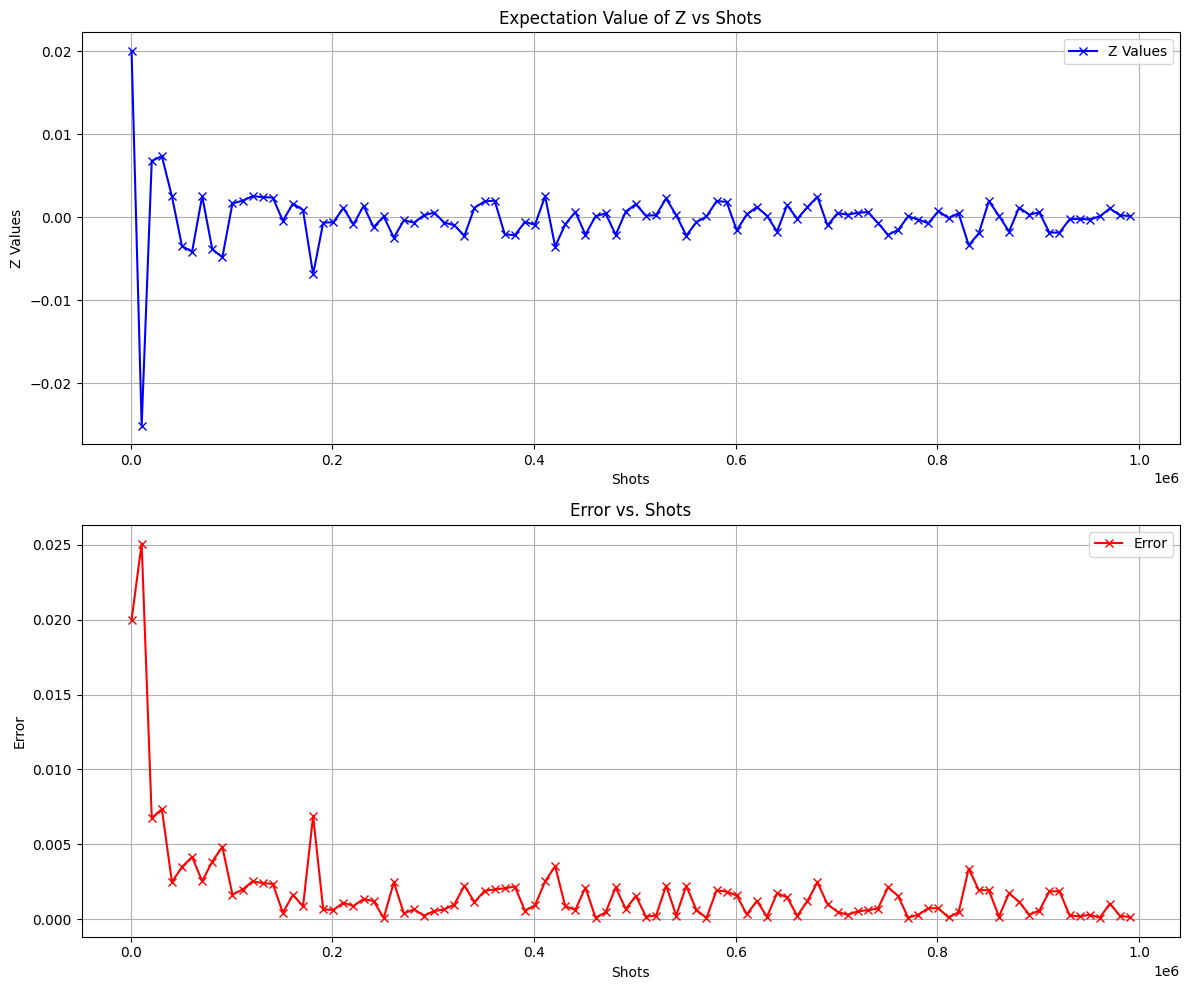

In [164]:
# Pair I
phi = np.pi/2
theta = np.pi/4
true_expected_value_1 = true_answer(theta, phi)

run_circuit_method_1(phi, theta, true_expected_value_1)
exp_value_pair_1 = exp_value_method_1

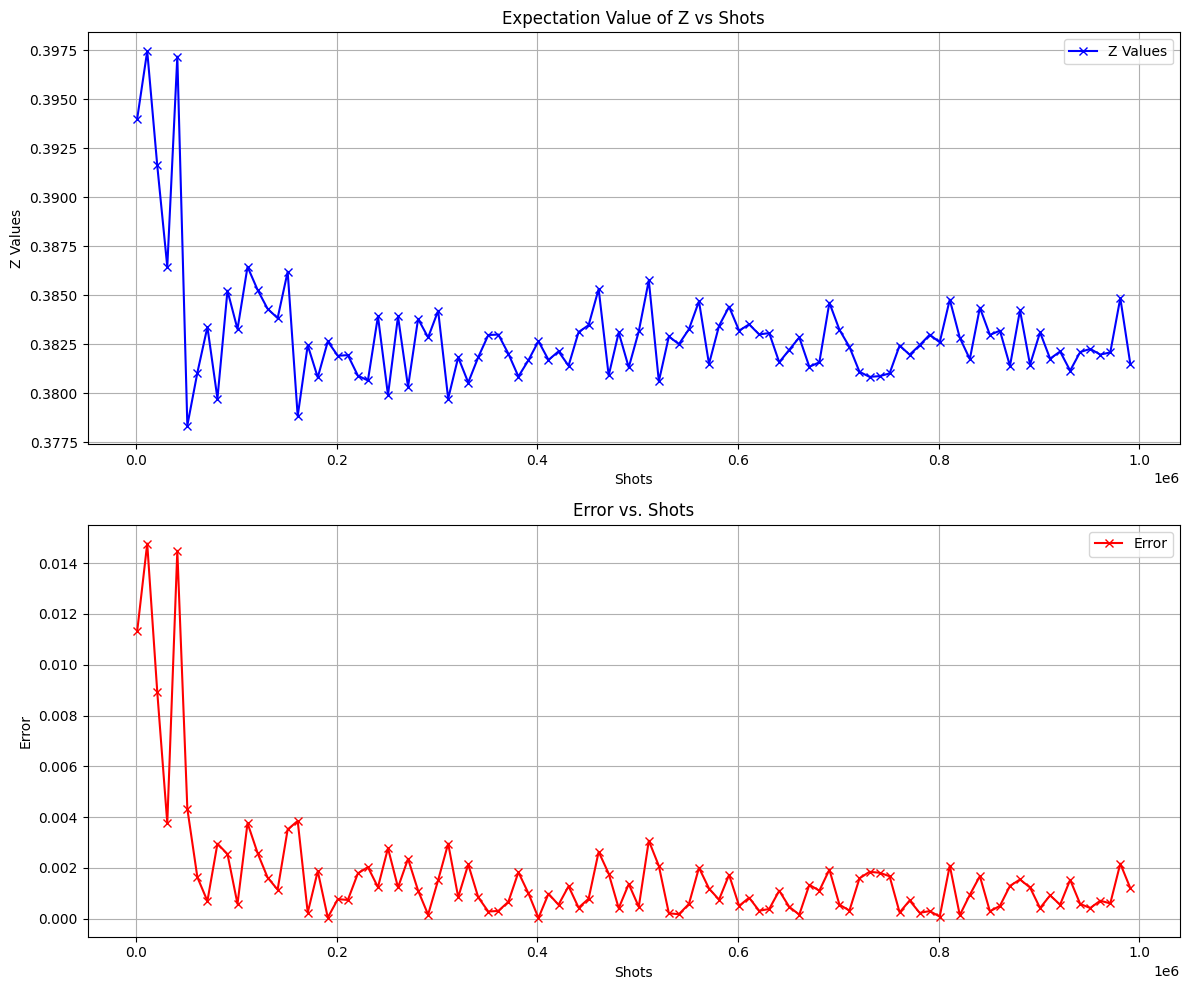

In [165]:
# Pair II

phi = np.pi/4
theta = np.pi/8
true_expected_value_2 = true_answer(theta, phi)
#print(f"{true_expected_value=}")

run_circuit_method_1(phi, theta, true_expected_value_2)
exp_value_pair_2 = exp_value_method_1

### Create Circuit Function

In [268]:
def create_qc(psi, U):
    """Create a quantum circuit given an initial state and unitary."""
    qr = QuantumRegister(1, 'q')  # Quantum register
    cr = ClassicalRegister(1, 'c')  # Classical register
    qc = QuantumCircuit(qr, cr)
    qc.initialize(psi, 0)  # Initialize the qubit
    qc.append(U, [0])  # Apply the unitary gate
    qc.measure(0, 0)  # Measure the qubit
    return qc

### Calculate Expectation Value of Z

In [269]:
def calculate_expectation(counts):
    """Calculate the expectation value of Z from the counts."""
    num_zeros = counts.get('0', 0)
    num_ones = counts.get('1', 0)
    return (num_zeros - num_ones) / 1024  # Normalise by total shots

### Run Sampler

In [270]:
def run_sampler(qc, sampler, shots=1024):
    """Run a quantum circuit using the given sampler."""
    job = sampler.run([qc], shots=shots)
    return job.result()[0].data['c'].get_counts()

## IBM Simulator and QPU Comparison

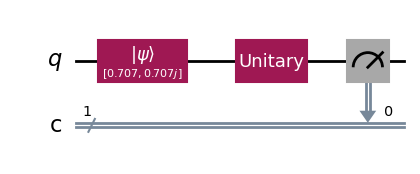

In [271]:
# Example Pair I for qc1
phi_1 = np.pi / 2
theta_1 = np.pi / 4
true_expected_value_1 = true_answer(theta_1, phi_1)

# Example Pair II for qc2
phi_2 = np.pi / 4
theta_2 = np.pi / 8
true_expected_value_2 = true_answer(theta_2, phi_2)

# Define initial states
psi_1 = Statevector([np.cos(phi_1), 1j * np.sin(phi_1)])
psi_2 = Statevector([np.cos(phi_2), 1j * np.sin(phi_2)])

# Define unitary gates
U1 = UnitaryGate((1 / np.sqrt(2)) * np.array([
    [1, 1],
    [np.exp(1j * theta_1), -np.exp(1j * theta_1)]
]).T.conj())

U2 = UnitaryGate((1 / np.sqrt(2)) * np.array([
    [1, 1],
    [np.exp(1j * theta_2), -np.exp(1j * theta_2)]
]).T.conj())

# Create circuits for both pairs
qc_1 = create_qc(psi_1, U1)
qc_2 = create_qc(psi_2, U2)

# Draw the circuits
qc_1.draw('mpl')
qc_2.draw('mpl')

### Aer Simulator

Expectation value of Z for pair 1 aer: 0.04492
Expectation value of Z for pair 2 aer: 0.33594
Actual error: pair 1 aer: 0.04492, pair 2 aer: 0.04675
{'1': 489, '0': 535} {'1': 340, '0': 684}


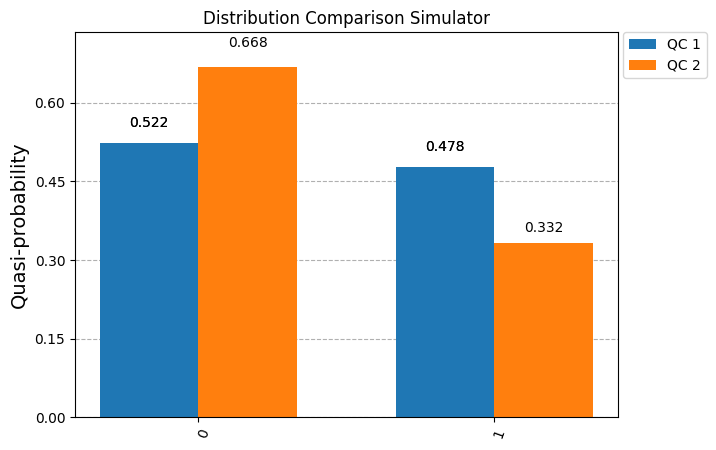

In [291]:
# Set backend
backend_aer = AerSimulator()

# Create Sampler instances
sampler_aer = Sampler(mode=backend_aer)

# Transpile the circuits for the backend
qc_t1_aer = transpile(qc_1, backend_aer)
qc_t2_aer = transpile(qc_2, backend_aer)

# Run the sampler jobs (with shots = 1024)
counts_1_aer = run_sampler(qc_t1_aer, sampler_aer)
counts_2_aer = run_sampler(qc_t2_aer, sampler_aer)

# Calculate expectation values
expectation_Z_1_aer = calculate_expectation(counts_1_aer)
expectation_Z_2_aer = calculate_expectation(counts_2_aer)

# Calculate the errors
error_1_aer = np.abs(expectation_Z_1_aer - true_expected_value_1)
error_2_aer = np.abs(expectation_Z_2_aer - true_expected_value_2)

# Print results
print(f"Expectation value of Z for pair 1 aer: {expectation_Z_1_aer:.5f}")
print(f"Expectation value of Z for pair 2 aer: {expectation_Z_2_aer:.5f}")
print(f"Actual error: pair 1 aer: {error_1_aer:.5f}, pair 2 aer: {error_2_aer:.5f}")

# Plot the distributions
plot_distribution([counts_1_aer, counts_2_aer], legend=['QC 1', 'QC 2'], title='Distribution Comparison Simulator')

### QPU

### Pair I

In [296]:
# Set backend
backend_sam = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
print(f"Selected backend: {backend_sam.name}")

# Create Sampler instances
sampler_sam = Sampler(mode=backend_sam)

# Transpile the circuits for the backend
qc_t1_sam = transpile(qc_1, backend_sam)

# Run the sampler jobs (with shots = 1024)
counts_1_sam = run_sampler(qc_t1_sam, sampler_sam)

# Calculate expectation values
expectation_Z_1_sam = calculate_expectation(counts_1_sam)

# Calculate the errors
error_1_sam = np.abs(expectation_Z_1_sam - true_expected_value_1)

# Print results
print(f"Expectation value of Z for pair 1 sampler: {expectation_Z_1_sam:.5f}")
print(f"Actual error for pair 1 sampler: {error_1_sam:.5f}")

Selected backend: ibm_kyiv


KeyboardInterrupt: 

### Pair II

In [300]:
# Set backend
backend_sam = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
print(f"Selected backend: {backend_sam.name}")

# Create Sampler instances
sampler_sam = Sampler(mode=backend_sam)

# Transpile the circuits for the backend
qc_t2_sam = transpile(qc_2, backend_sam)

# Run the sampler jobs (with shots = 1024)
counts_2_sam = run_sampler(qc_t2_sam, sampler_sam)

# Calculate expectation values
expectation_Z_2_sam = calculate_expectation(counts_2_sam)

# Calculate the errors
error_2_sam = np.abs(expectation_Z_2_sam - true_expected_value_2)

# Print results
print(f"Expectation value of Z for pair 2 sampler: {expectation_Z_2_sam:.5f}")
print(f"Actual error for pair 2 sampler: {error_2_sam:.5f}")

Selected backend: ibm_kyiv


qiskit_runtime_service.check_pending_jobs:WARNING:2024-12-31 20:24:04,206: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cxt1x85y1ae0008n53hg', 'sampler')> to finish before submitting the next one.


KeyboardInterrupt: 

### Retrieve counts from QPU qiskit code

In [375]:
#Pair I
job = service.job('cxt2bh6wk6yg008hv8c0')
job_result = job.result()

count_pair_1 = job_result[0].data['c'].get_counts()
expectation_Z_1_sam = calculate_expectation(count_pair_1)
print(f"Expectation value of Z for pair 1 sampler: {expectation_Z_1_sam:.5f}")
print(count_pair_1)


Expectation value of Z for pair 1 sampler: 0.02930
{'0': 527, '1': 497}


In [344]:
#Pair II
job = service.job('cxt2j200v1500080cyvg')
job_result = job.result()

count_pair_2 = job_result[0].data['c'].get_counts()
expectation_Z_2_sam = calculate_expectation(count_pair_2)
print(f"Expectation value of Z for pair 1 sampler: {expectation_Z_2_sam:.5f}")

Expectation value of Z for pair 1 sampler: 0.41016


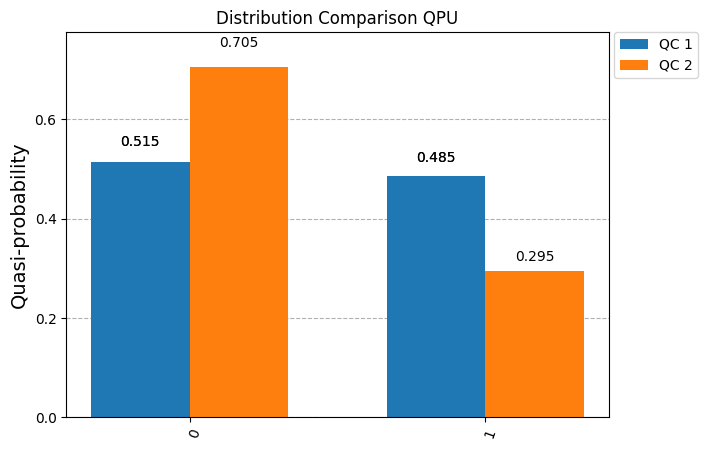

In [345]:
# Plot the distributions
plot_distribution([count_pair_1, count_pair_2], legend=['QC 1', 'QC 2'], title='Distribution Comparison QPU')

In [295]:
job = service.job('cxt1gx30827000842tt0')
job_result = job.result()

# To get counts for a particular pub result, use 
pub_result_1 = job_result[0].data['c'].get_counts()
print(pub_result_1)
print(f"Counts for job 1-- QPU: {pub_result_1}")

expectation_Z_1_sam = calculate_expectation(pub_result_1)
print(f"Expectation value of Z for pair 1 sampler: {expectation_Z_1_sam:.5f}")
plot_distribution([pub_result_1], legend=['QC 1'], title='Distribution Comparison Simulator Method 1')

1
{'1': 500, '0': 524}
Counts for job 1-- QPU: {'1': 500, '0': 524}
Expectation value of Z for pair 1 sampler: 0.02344


# Method II

## using estimator

In [166]:
def measure_X_and_Y_exps(qc: QuantumCircuit):
    """Measure a circuit with respect to X and Y observables."""
    observables = [SparsePauliOp('X'),SparsePauliOp('Y')]

    estimator = Estimator(AerSimulator())
    pub = (qc, observables)

    job = estimator.run(pubs=[pub])
    #print(job.result())
    return job.result()[0].data.evs

def run_circuit_method_2(phi, theta):
    """Calculate expectation of M using Method II."""
    psi = Statevector([np.cos(phi), 1j * np.sin(phi)])

    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    qc.initialize(psi, 0)

    x_exp, y_exp = measure_X_and_Y_exps(qc)

    m_exp = np.cos(theta)* x_exp + np.sin(theta)*y_exp
    #print(f"Expected value of m: {m_exp}")
    return m_exp

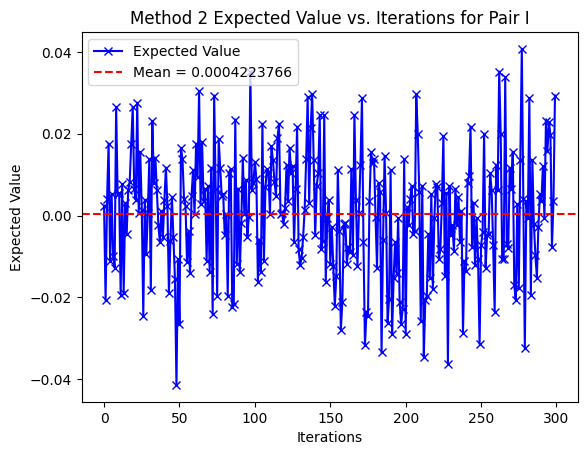

In [167]:
# Pair I
phi = np.pi/2
theta = np.pi/4
true_expected_value = true_answer(theta, phi)
#print(f"{true_expected_value=}")

exp_values_method_2 = []
x_values = [i for i in range(300)]
for i in x_values:
    exp_values_method_2.append(run_circuit_method_2(phi, theta))

plt.plot(x_values, exp_values_method_2, marker='x', linestyle='-', color='b', label='Expected Value')

# Calculate the mean of the results
mean_value_1 = np.mean(exp_values_method_2)
# Plot the mean as a red horizontal line
plt.axhline(y=mean_value_1, color='r', linestyle='--', label=f'Mean = {mean_value_1:.10f}')

plt.xlabel('Iterations')
plt.ylabel('Expected Value')
plt.title('Method 2 Expected Value vs. Iterations for Pair I')
plt.legend()
plt.show()

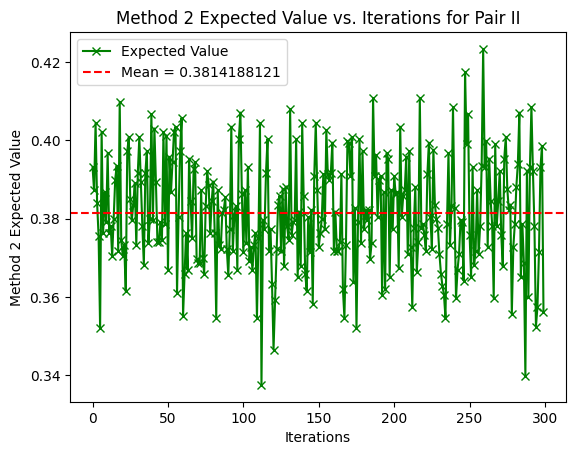

In [168]:
# Pair II

phi = np.pi/4
theta = np.pi/8
true_expected_value = true_answer(theta, phi)
#print(f"{true_expected_value=}")

exp_values_method_2 = []
x_values = [i for i in range(300)]
for i in x_values:
    exp_values_method_2.append(run_circuit_method_2(phi, theta))

plt.plot(x_values, exp_values_method_2, marker='x', linestyle='-', color='g', label='Expected Value')

# Calculate the mean of the results
mean_value_2 = np.mean(exp_values_method_2)
# Plot the mean as a red horizontal line
plt.axhline(y=mean_value_2, color='r', linestyle='--', label=f'Mean = {mean_value_2:.10f}')
plt.xlabel('Iterations')
plt.ylabel('Expected Value')
plt.title('Method 2 Expected Value vs. Iterations for Pair II')
plt.legend()
plt.show()


## Simulator Comparison between method I and II

In [169]:
# Calculating percentage errors
percentage_error_1_method_1 = (np.abs((exp_value_pair_1) - true_expected_value_1))
percentage_error_2_method_1 = (np.abs((exp_value_pair_2) - true_expected_value_2) / np.abs(true_expected_value_2)) * 100
percentage_error_1_method_2 = (np.abs((mean_value_1) - true_expected_value_1))
percentage_error_2_method_2 = (np.abs((mean_value_2) - true_expected_value_2) / np.abs(true_expected_value_2)) * 100

# Create a dataframe to compare the results
data = {
    'X': ['Pair 1', 'Pair 2'],
    'Method 1': [exp_value_pair_1, exp_value_pair_2],
    'Error Method 1 (%)': [percentage_error_1_method_1, percentage_error_2_method_1],
    'Method 2': [mean_value_1, mean_value_2],
    'Error Method 2 (%)': [percentage_error_1_method_2, percentage_error_2_method_2],
    'True Results': [true_expected_value_1.real, true_expected_value_2.real],
}

df = pd.DataFrame(data)

# Print the table
print(df)

        X  Method 1  Error Method 1 (%)  Method 2  Error Method 2 (%)  \
0  Pair 1  0.000137            0.000137  0.000422            0.000422   
1  Pair 2  0.381481            0.314124  0.381419            0.330461   

   True Results  
0  8.659561e-17  
1  3.826834e-01  


## using QPU

In [352]:
def measure_X_and_Y_exps(qc: QuantumCircuit, backend):
    """Measure a circuit with respect to X and Y observables."""
    observables = [SparsePauliOp('X'),SparsePauliOp('Y')]

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(qc)
    isa_observable = [observables[0].apply_layout(isa_circuit.layout), observables[1].apply_layout(isa_circuit.layout)]
    
    estimator = Estimator(backend)
    job = estimator.run([(isa_circuit, isa_observable)])
    print(job.result())
    return job.result()[0].data.evs

def run_circuit_method_2(phi, theta, backend):
    """Calculate expectation of M using Method II."""
    psi = Statevector([np.cos(phi), 1j * np.sin(phi)])

    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    qc.initialize(psi, 0)

    x_exp, y_exp = measure_X_and_Y_exps(qc, backend)

    m_exp = np.cos(theta)* x_exp + np.sin(theta)*y_exp
    print(f"Expected value of m: {m_exp}")
    return float(m_exp)

In [355]:
# Pair I
run_circuit_method_2(phi_1, theta_1, backend_aer)
run_circuit_method_2(phi_1, theta_1, backend_sam)

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(2,), dtype=float64>), stds=np.ndarray(<shape=(2,), dtype=float64>), shape=(2,)), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})], metadata={'version': 2})


KeyboardInterrupt: 

In [371]:
job = service.job('cxt389hy1ae0008n54gg')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [ 0.01279427 -0.0209826 ]


In [356]:
# Pair II
run_circuit_method_2(phi_2, theta_2, backend_aer)
run_circuit_method_2(phi_2, theta_2, backend_sam)

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(2,), dtype=float64>), stds=np.ndarray(<shape=(2,), dtype=float64>), shape=(2,)), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})], metadata={'version': 2})
PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(2,), dtype=float64>), stds=np.ndarray(<shape=(2,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(2,), dtype=float64>), shape=(2,)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigatio

0.38639876156187686

In [370]:
job = service.job('cxt3a604a290008xrd8g')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [0.00442913 0.99901575]


In [369]:
#Pair II
pair_2_method_2_aer = run_circuit_method_2(phi_2, theta_2, backend_aer)
pair_2_method_2_sam = run_circuit_method_2(phi_2, theta_2, backend_sam)
print(f"Pair 2 Method 2 Aer: {pair_2_method_2_aer}")
print(f"Pair 2 Method 2 Sam: {pair_2_method_2_sam}")

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(2,), dtype=float64>), stds=np.ndarray(<shape=(2,), dtype=float64>), shape=(2,)), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})], metadata={'version': 2})


KeyboardInterrupt: 

In [383]:
job = service.job('cxt3enj4a290008xrdb0')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")


Expectation values for pub 0: [0.00342801 0.99608227]
